## AE2 Sentiment Analysis

This report documents the training for the GLUE SST-2 sentiment analysis model task.

In [1]:
#Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

### 1. Data Exploration
The first step of the machine learning application development is to explore our data sets and evaluate their suitability for the project.
For this project we have three data sets: one for training, one for the development of the model and one for testing its success at the very end. The first two data sets are labeled, meaning that each data sample is already classified. The testing set is unlabled, as this is what the model should be able to predict in the end. <br>
The data used for this machine learning application is based on movie reviews. Each sample is a review sentence labeled as having either postive or negative sentiment. Hence, we are working with two classes.

In [2]:
#Load data files using pandas and store them as dataframes

#Training Data
data1 = pd.read_csv('train.tsv', sep = '\t')

#Developing Data
data2 = pd.read_csv('dev.tsv', sep = '\t')

In [3]:
data1.head(5)

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0


In [4]:
#Create function to plot data distribution
def plot_dist (df, title):
    """
    Creates bar plot showing distribution of positive and negative reviews in a data set.
    
    """
    
    label_count = df['label'].value_counts()

    #Draw plot and specify lables and styles
    plt.figure(figsize=(5,3))
    plt.bar(label_count.index, label_count.values)
    plt.title(f'Data Distribution:\n {title}', pad=10)
    plt.xticks(label_count.index, ['Negative', 'Positive'])
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Sentences')

    plt.show

    print(f'The label difference is: {label_count[0]-label_count[1]}')
    
    return

The label difference is: -7789


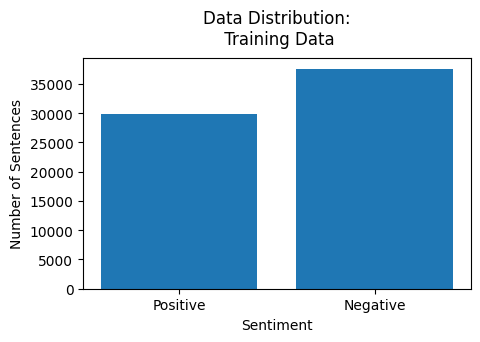

In [5]:
#Call plot function for training data and print difference
plot_dist(data1, 'Training Data')

The label difference is: -16


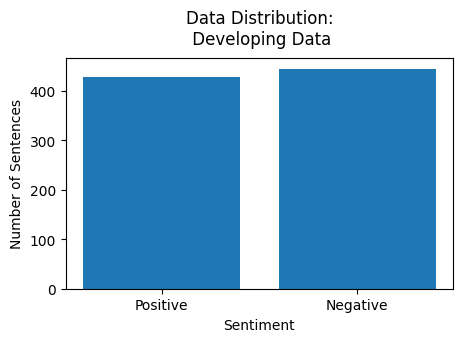

In [6]:
#Call plot function for developing data and print difference
plot_dist(data2, 'Developing Data')

Comparing the two data visualisations we find two things. <br>
1. The data set for testing the training model is a lot smaller with about 900 samples, while the training data has about 67,000 sample reviews. This is not suprising, nor worrying though. <br>
2. The second observation regards the distribution of the labels in each data set. The testing (developing) set has a nearly equal distribution. This is appropriate seeing that the model should be capable of predicting both labels. The training data though, shows a significant difference in label counts, of 7,789 samples, skewed towards the negtative label. This difference could affect the training of the model, which may be biased towards the negative class. Further, we may find that the generalisation for the positive class is  impaired. As the difference is under 25% though, we will precede with the data set as it is, without taking measures. However, this decision should be reevaluated at the end of the project.

We conclude that the data sets are large enough and well distributed enough to proceed with the further processing in preparation of the machine learning model training.

### 2. Data Vectorisation

In order to be able to model the text data in quantitative terms the next step is to vectorise the data. There are multiple ways of doing this. In order to find the best way for our data, we try multiple methods and compare them. To do this we train the different methods on the training data set and then train a classification model based on this vectorisation of the data. Next, we measure the accuracy of predictions made by this model on both the training data set, as well as a test data set that was unseen by the vectorizer.  

In [7]:
#Create data structure that stores sentence-sentiment pairs of our data sets
class Dataset(object):
    """
    A helper data structure to store the input features (X) and labels (y) of a dataset.
    """
    def __init__(self):
        self.X = None
        self.y = None
        # Vectorized input text features
        self.V = None

#Create two objects of type Dataset
train = Dataset()
test = Dataset()

#Store columns from dataframes in objects
train.X = data1["sentence"]
train.y = data1["label"]

test.X = data2["sentence"]
test.y = data2["label"]

#### Ablation Study of Different Vectorization Methods
We will use two different basic vectorization methods and apply them using different parameters. They are the word count vectorizer and TF-IDF vectorizer. We can then modify these with some extra parameters such as discarding stop words.

In [8]:
#Create class called vectorizers with the description and commands for different vectorizers
vectorizers = {
    'Word Count':                                     CountVectorizer(),
    'Word Count w/stp wrds':                        CountVectorizer(stop_words="english"),
    'TF-IDF':                                         TfidfVectorizer(),
    'TF-IDF w/stp wrds':                            TfidfVectorizer(stop_words="english"),
    'TF-IDF w/stp wrds, min-df 3':               TfidfVectorizer(stop_words="english", 
                                                                      min_df=3),
    'TF-IDF w/stp wrds, (1, 2)-grams':              TfidfVectorizer(stop_words="english", 
                                                                      ngram_range=(1,2)),
    'TF-IDF w/stp wrds, min-df 3, (1, 2)-grams': TfidfVectorizer(stop_words="english", 
                                                                      min_df=3, 
                                                                      ngram_range=(1,2)),
}


#For storing results
descriptions = []
num_features = []
training_accuracies = []
test_accuracies = []

#Create loop function that fits each vectoriser to training model and tests the outcome when used for a multinomial naive bayes classifier
for description, vectorizer in vectorizers.items():

    # Create the vectorizer based on the training data
    vectorizer.fit(train.X)
    
    # Encode the words in the training and test dataset based on the vocabulary
    train.V = vectorizer.transform(train.X)
    test.V = vectorizer.transform(test.X)
    
    # Train the classifier on the training data
    model = MultinomialNB(alpha=0.5).fit(X=train.V, y=train.y)


    #Store results
    descriptions.append(description)
    num_features.append(len(vectorizer.get_feature_names_out()))
    training_accuracies.append(model.score(train.V, train.y))
    test_accuracies.append(model.score(test.V, test.y))

    #Print results
    print(f'\n{description}\n')
    
    print("- Number of features: {:6d}".format(len(vectorizer.get_feature_names_out())))

    print("- Training accuracy:  {:.2%}".format(model.score(train.V, train.y)))
    print("- Test accuracy:      {:.2%}".format(model.score(test.V, test.y)))


Word Count

- Number of features:  13774
- Training accuracy:  89.67%
- Test accuracy:      80.39%

Word Count w/stp wrds

- Number of features:  13491
- Training accuracy:  88.98%
- Test accuracy:      78.10%

TF-IDF

- Number of features:  13774
- Training accuracy:  90.87%
- Test accuracy:      79.82%

TF-IDF w/stp wrds

- Number of features:  13491
- Training accuracy:  90.02%
- Test accuracy:      77.41%

TF-IDF w/stp wrds, min-df 3

- Number of features:  12342
- Training accuracy:  89.81%
- Test accuracy:      77.87%

TF-IDF w/stp wrds, (1, 2)-grams

- Number of features:  62753
- Training accuracy:  93.53%
- Test accuracy:      77.75%

TF-IDF w/stp wrds, min-df 3, (1, 2)-grams

- Number of features:  49573
- Training accuracy:  92.98%
- Test accuracy:      77.98%


Let's plot this information for better insight.

In [9]:
#Make dataframe from results
results = pd.DataFrame({'Method':descriptions, 'Number of features': num_features,
                        'Training accuracy':training_accuracies, 'Test accuracy':test_accuracies})

#Write function to make plot
def ablation_plot(df, title):
    """
    Creates bar plot of data frame containing accuracies of different vectorisation methods
    """
    plt.figure(figsize=(9,3.5))

    bar_width = 0.2

    r = np.arange(len(df['Method']))

    plt.barh(r - bar_width/2, df['Training accuracy'], height=bar_width, label='Fitting accuracy')
    plt.barh(r + bar_width/2, df['Test accuracy'], height=bar_width, label='Prediction accuracy')

    plt.xlabel('Accuracy')
    plt.ylabel('Method')
    plt.title(f'{title}')
    plt.yticks(r, df['Method'], ha='right')

    plt.xlim(0.5,1)

    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()
    return

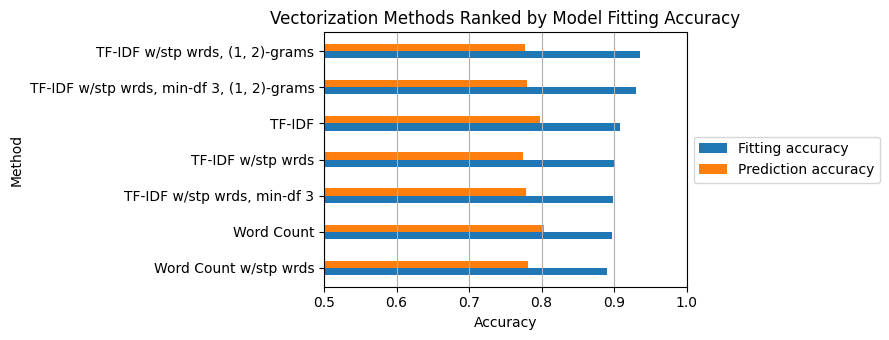

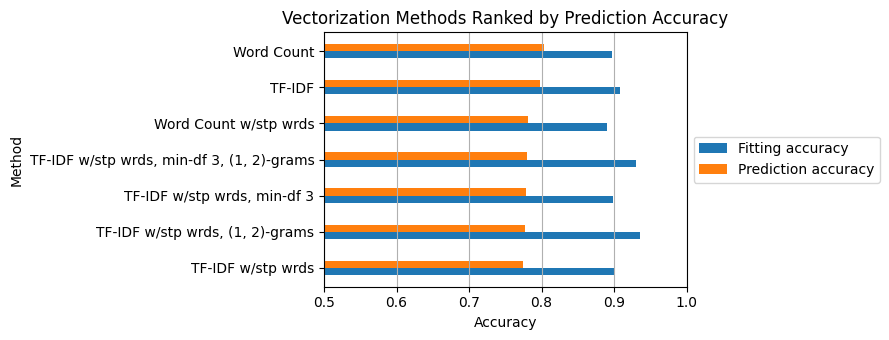

In [10]:
#Create sorted data frames
sorted_results_tr = results.sort_values(by='Training accuracy')
sorted_results_te = results.sort_values(by='Test accuracy')

#Call function on both sorted arrays
ablation_plot(sorted_results_tr, "Vectorization Methods Ranked by Model Fitting Accuracy")

ablation_plot(sorted_results_te, "Vectorization Methods Ranked by Prediction Accuracy")

The two graphs above rank the different vectorization methods once by accuracy of the predictions for the training data set and once for the testing data set. Comparing them we can see large differences. The accuracy for the training data set shows us how well the model is fitted to the training data. Because the labels are known during the model training, the highest score is not necessarily the most desirable, as this could mean overfitting. The accuracy for the test data set on the other hand tells us how well the model predicts previously unkonwn labels. Therefore it is unsurprising that all models score lower for this data set. <br>
When it comes to chosing the best model two things should be considered. A model that scores high on the test data should be favored, since this indicates how well the model has generalised the data and how well it will do for future prediction tasks. A perfect score in accuracy for a training is not of much use, as this is likely to indicate overfitting. Secondly, a model that shows a small gap between the test and training data accuracies could also be favorable.
<br>
<br>
Taking this as a guide it seems that the 'TD-IDF' method seems to be the best choice for our purposes. While it ranks only second behind the 'word count' method in prediction accuracy, with a difference of about 0.6%, it is in third place in terms of fitting accuracy, while the 'word count' method is second to last in this respect. This choice should strike a good balance between fitting and generalisation.

In [11]:
#Intitialise final vectoriser with chosen method
my_vectorizer =  TfidfVectorizer()

#Train vectorizer on training data set
my_vectorizer.fit(train.X)

#Save model
with open("vectorizer.pickle", "wb") as f:
    pickle.dump(my_vectorizer, f)

#Vectorise sentences in both data sets
train.V = my_vectorizer.transform(train.X)
test.V = my_vectorizer.transform(test.X)

### 3. Machine Learning Model

After having decided on a vectorisation method we now move on to choosing a machine learning classifier. To do this we undergo a similar process as in the last step. <br>
We decided to go with the logistic regression and naive bayes classifiers, as the other known options were taking too much computing power to train. <br>
In order to test the efficiency and effectivity of the models we will time the amount of time it takes to train the models, as well as the time it takes to apply the model onto a set of data. We will also assess the accuracy, recall score, precision and F1 score of our two models and plot them for comparison.

In [12]:
#Create class called classifiers with the description and commands for different classification methods
classifiers = {
    'Logistic Regression':       LogisticRegression(),
    'Naive Bayes':               MultinomialNB(),
    #'KNN':                       KNeighborsClassifier(),
    #'Decision Tree':             DecisionTreeClassifier(),
}

In [13]:
#Create empty list to save scores of each model
results = []

#Create for loop to fit model onto data and assess accuracy of predictions which are saved to our results list
for name, classifier in classifiers.items():

    #Record start time for training
    train_start = time.time()
    
    #Fit model on training data set
    classifier.fit(X=train.V, y=train.y)

    #Record end time for training
    train_end = time.time()

    #Record start time for prediction
    prediction_start = time.time()
    
    #Make predictions using model
    train_pred = classifier.predict(train.V)
    test_pred = classifier.predict(test.V)

    #Record end time for prediciotn
    prediciton_end = time.time()
    
    #Assess accuracy, precision, recall and f1 scores
    train_accuracy = accuracy_score(train.y, train_pred)
    test_accuracy = accuracy_score(test.y, test_pred)
    train_precision = precision_score(train.y, train_pred)
    test_precision= precision_score(test.y, test_pred)
    train_recall = recall_score(train.y, train_pred)
    test_recall = recall_score(test.y, test_pred)
    train_f1 = f1_score(train.y, train_pred)
    test_f1 = f1_score(test.y, test_pred)

    #Calculate training and prediction times
    training_time = train_end - train_start
    prediction_time = prediciton_end - prediction_start
    
    #Save result
    results.append({'Classifier': name, 'Training Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 
                    'Training Precision': train_precision, 'Test Precision': test_precision, 'Training Recall': train_recall,
                    'Test Recall': test_recall, 'Training F1': train_f1, 'Test F1': test_f1, 'Training Time': training_time, 
                    'Prediction Time': prediction_time
                   })

In [14]:
#Convert results to data frame
df_results = pd.DataFrame(results)
#Look at results
df_results.head(2)

,Classifier,Training Accuracy,Test Accuracy,Training Precision,Test Precision,Training Recall,Test Recall,Training F1,Test F1,Training Time,Prediction Time
0,Logistic Regression,0.922107,0.822248,0.926121,0.800416,0.934946,0.867117,0.930513,0.832432,1.013184,0.003280
1,Naive Bayes,0.905819,0.800459,0.905975,0.766798,0.927414,0.873874,0.916569,0.816842,0.018196,0.006357


In [15]:
#Write function to plot efficiency results
def efficiency_plot (df, title1, title2):
    """
    Creates a bar plot from a data frame showing training and prediction times for different classification models
    """
    plt.figure(figsize=(8,3))

    r = np.arange(len(df['Classifier']))

    #Create first subplot for training times
    plt.subplot(1,2,1)
    plt.bar(r, df['Training Time'],  label='training time')

    plt.ylabel('Time in s')
    plt.xlabel('Classifier')
    plt.xticks(r, df['Classifier'])
    plt.title(f'{title1}')
    plt.grid(axis='y')

    #Create second subplot for prediction times
    plt.subplot(1,2,2)
    plt.bar(r, df['Prediction Time'], label='prediction time')

    plt.ylabel('Time in s')
    plt.xlabel('Classifier')
    plt.xticks(r, df['Classifier'])
    plt.title(f'{title2}')
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    return

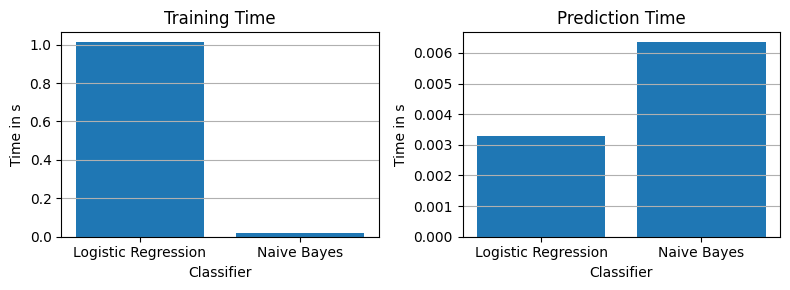

In [16]:
#Call function for plotting
efficiency_plot(df_results, 'Training Time', 'Prediction Time')

Our plots above visualise the time it took to train our two classifiers and the time the models took to make predictions on our data sets. Regarding the training time the logistic regression classifier took significantly longer with over 1s, while the naive bayes classifier took less than 0.1s. In terms of the training process then, the latter is a lot more efficient. When it comes to the run times for the predicitons, the difference is not that large. Overall, given the size of our data sets, both models ran for less than 0.01s. In this case though, the logistic regression model ran slightly faster.
Considering that training is performed only once and the real time deployment time of the model will be more important for further use, the prediction time indicator should be prioritised. Seeing that the logistic regression model is slightly faster here, it seems to make a good candidate as our chosen model.

In [17]:
print(f'The exact time it took for the logistic regression classification model to be trained was: {df_results.at[0, "Training Time"]}s')
print(f'The exact time it took for the naive bayes classification model to be trained was: {df_results.at[1, "Training Time"]}s')
print(f'The exact time it took for the logistic regression classification model to predict unknown labels was: {df_results.at[0, "Prediction Time"]}s')
print(f'The exact time it took for the logistic regression classification model to predict unkonwn labels was: {df_results.at[0, "Prediction Time"]}s')

The exact time it took for the logistic regression classification model to be trained was: 1.0131840705871582s
The exact time it took for the naive bayes classification model to be trained was: 0.01819586753845215s
The exact time it took for the logistic regression classification model to predict unknown labels was: 0.003280162811279297s
The exact time it took for the logistic regression classification model to predict unkonwn labels was: 0.003280162811279297s


In addition to our evaluation of the run times we cann also assess the models' success in predicting a sentence's label. To do this we can use four different metrics. All metrics work with counts of true and false positive and negative labels. In our specific case positive labels will correspond to positive sentiment labels, while negative corresponds to a negative sentiment label.

1. Accuracy tells us how how many out of all the predicitons made by the model were correct.

$$accuracy = \frac{true \ positives + true \ negatives}{true \ positives + true \ negatives + false \ positives + false \ negatives}$$

2. Precision tells us how many out of all __positive__ predictions are __true__ positives.

$$precision = \frac{true \ positives}{true \ positives + false \ positives}$$

3. Recall tells us how many of the sentences that should be labeled positive were actually labeled positive.

$$recall = \frac{true \ positives}{true \ positives + false \ negatives}$$

4. The F1 score combines recall and precision, measuring how well the model manages the trade off between the two.

$$f1 = 2* \frac{precision*recall}{precision + recall}$$


(https://www.labelf.ai/blog/what-is-accuracy-precision-recall-and-f1-score)


In [18]:
#Write function to plot 4 evaluation scores
def classifier_plot(df, title1, title2):
    """
    Creates bar plot from data frame showing assessment scores of different classification methods
    """
    plt.figure(figsize=(11,4))

    bar_width = 0.2

    r = np.arange(len(df['Classifier']))

    #Create first subplot for training results
    plt.subplot(1,2,1)
    plt.barh(r, df['Training Accuracy'], height=bar_width, label='training accuracy')
    plt.barh(r + bar_width, df['Training Precision'], height=bar_width, label='training precision')
    plt.barh(r + 2*bar_width, df['Training Recall'], height=bar_width, label='training recall')
    plt.barh(r + 3*bar_width, df['Training F1'], height=bar_width, label='training F1')

    plt.xlabel('Accuracy')
    plt.ylabel('Classifier')
    plt.title(f'{title1}')
    plt.yticks(r, df['Classifier'], ha='right')
    plt.xlim(0.5,1)
    plt.grid(axis='x')

    #Create second subplot for testing results
    plt.subplot(1,2,2)
    plt.barh(r, df['Test Accuracy'], height=bar_width, label='Accuracy')
    plt.barh(r + bar_width, df['Test Precision'], height=bar_width, label='Precision')
    plt.barh(r + 2*bar_width, df['Test Recall'], height=bar_width, label='Recall')
    plt.barh(r + 3*bar_width, df['Test F1'], height=bar_width, label='F1')


    plt.xlabel('Score')
    plt.ylabel('Classifier')
    plt.title(f'{title2}')
    plt.yticks(r, df['Classifier'], ha='right')
    plt.xlim(0.5,1)
    plt.grid(axis='x')
    
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
    plt.show()
    return

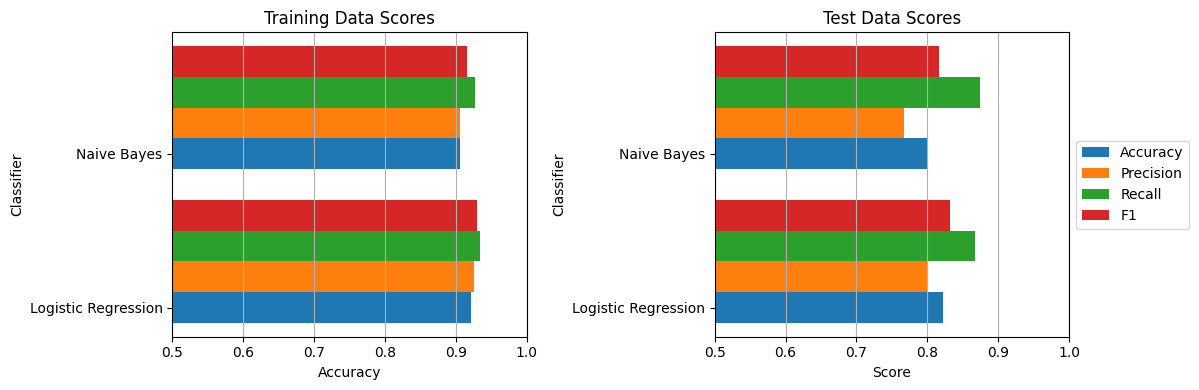

In [19]:
#Call function for plotting
classifier_plot(df_results, 'Training Data Scores', 'Test Data Scores')

The training data scores show that overall the logistic regression classifier did better at fitting the model to the training data measured by all four metrics. The difference was not too large though with both the naive bayes classifier and the logistic regression classifier scoring above 90% and under 93% in all four measures. <br>
The test data scores show a slightly more differentiated picture. The worst score was achieved by the naive bayes classifier on the test data when tested for precision with around 78%. The best score was also achieved by the naive bayes classifier in the recall score with aroudn 87%. This is very closely followed by the logistic regression recall score. In accuracy, precisoin and f1 scores the logistic regression classifier is the superior one. It's accuracy score lies at around 82% while the naive bayes classifier scores about 80% in accuracy. <br> <br>
For our purposes we will continue fine tuning the logistic regression model on our data, as it provides both the higher accuracy, as well as higher prediction speed out of the two models investigated.

### 4. Hyper-Parameters
Now that we have decided on a classification model we can move on to tuning some possible hyper-parameters. The goal is to find an optimal combination of parameters for the modelling of our data set.

In [20]:
#First we get and print out the list of all hyper-parameters for our classifier
print('Logistic regression hyper-parameters  \n')
params =LogisticRegression().get_params()
for param, default in params.items():
        print(f'...{param:25s}: {default}')
print()

Logistic regression hyper-parameters  

...C                        : 1.0
...class_weight             : None
...dual                     : False
...fit_intercept            : True
...intercept_scaling        : 1
...l1_ratio                 : None
...max_iter                 : 100
...multi_class              : auto
...n_jobs                   : None
...penalty                  : l2
...random_state             : None
...solver                   : lbfgs
...tol                      : 0.0001
...verbose                  : 0
...warm_start               : False



The literature suggests that it for the size and purposes of our data set, it should not be necessary to tune all hyper-parameters available. In order to see what parameters are a viable option for tuning we will try out some combinations and check the run times.

In [21]:
#Initialise a classifier to test some hyperparameters for their run times
test_class = LogisticRegression(solver='saga', C=100, penalty='l2')

#Run model fitting
test_class.fit(X=train.V, y=train.y)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=100, solver='saga')

The tests have suggested settling on setting the penalty to 'l2' and tunign the parameters C and solver. The solver determines the algorithm used for optimisation. The penalty parameter aims at preventing generalisation errors and overfitting (scikit-learn). Furthermore Ccontrols the penalty strength. The solvers 'sag' and 'saga' will be disregarded as they do not lead to the model converging, suggesting that they are unsuitable algorithms for the data at hand.
<br> <br>
In the following, the optimal values for C and solver  will be tested for our data using a grid search. A grid search allows us to test all possible combinations of parameter values. It should be noted, that not every penalty works with every solver type. This is why we are setting the penalty to 'l2'. Further, certain C values have shown to not . Lastly, the newton-cholsky is too computationally expensive due to its hessian matrix which is why it will not be tested in the grid search.

In [22]:
#Grid search for the best combination of hyperparameters

# Create the classifier
my_classifier = LogisticRegression(penalty='l2', max_iter=200)

# Parameters to search, and possible values
grid = {
    'solver': ['lbfgs', 'liblinear'],
    'C' : [0.5, 1.0, 8, 10, 50, 100]
}

#Initialise grid search using the GridSearchCV method on our chosen classifier using the grid and setting the cross validation generator to 5  
my_gs = GridSearchCV(estimator= my_classifier, param_grid = grid, cv=5)

my_gs.fit(X=train.V, y=train.y);


In [23]:
#Print the best hyper-parameters found in the grid search
my_gs.best_params_

{'C': 50, 'solver': 'liblinear'}

In [24]:
#Show the highest accuracy for training data
print(f'Best training accuracy is {my_gs.best_score_:.2%}')

#Show the highest accuracy for test data
print(f'Test accuracy is {my_gs.score(test.V, test.y):.2%}')

Best training accuracy is 90.62%
Test accuracy is 80.85%


The grid search seems unsuccessful, as the default parameters still achieve a higher accuracy with 82% than the model specifications found through tuning which gave an accuracy of 81%. <br>
Implications: Depending on the purpose of a machine learning application it may or may not be worth spening the computational power for fine tuning a classification model. Surely, even better hyper-parameters could have been found, but this incremental improvement may not be of necessity for the purposes of the model and the predictions it is meant to make. <br>
Conclusion: The best model found in this exploration was the logistic regression classifier using defaul parameters. 

In [25]:
#Initialise model
my_model = LogisticRegression()

#Train model
my_model.fit(X=train.V, y=train.y)

#Save model
with open("classifier.pickle", "wb") as f:
    pickle.dump(my_model, f)

### 5. Model Deployment

Now that we have settled on our two models for vectorisation and classification we can deploy them to other reviews that are yet unlabled or a whole dataset of unlabled reviews and let the model predict the sentiment. First we need to make sure the new data has the same format and structure as our training and test data (apart from the lack of a label). 

In [26]:
#Load data file using pandas and store it as dataframe
unseen_data = pd.read_csv('test.tsv', sep = '\t')

#Check some of the data
unseen_data.head(5)


,index,sentence
0,0,uneasy mishmash of styles and genres .
1,1,this film 's relationship to actual tension is...
2,2,"by the end of no such thing the audience , lik..."
3,3,director rob marshall went out gunning to make...
4,4,lathan and diggs have considerable personal ch...


The format of the data looks good. The data is already tokenized as sentences, lowercase and the sentences are unlabled. We merely need to put the data in the same kind of data structure that we used for the other two data sets.

In [27]:
#Create new instance of object of type Dataset
evaluation = Dataset()

#Store sentences from dataframe in object
evaluation.X = unseen_data['sentence']

Now we can move on to deploying our two models. Of course the models are saved in this notebook, but as we want them to be deployable in real time outside of this script we will be using the saved model files for good practice, ensuring that they work as intended.

In [28]:
#Load vectorizer file
with open('vectorizer.pickle', 'rb') as f:
    vectorizer = pickle.load(f)

#Apply to new data and store in object
evaluation.V = vectorizer.transform(evaluation.X)

In [29]:
#Load classifier file
with open('classifier.pickle', 'rb') as f:
    classifier = pickle.load(f)

#Apply to vectorized new data
evaluation.y = classifier.predict(evaluation.V)

In [30]:
#Creat a new dataframe with labled data
final_result = unseen_data.copy()
final_result['label'] = evaluation.y

In [31]:
#Check it worked
final_result.head(10)

,index,sentence,label
0,0,uneasy mishmash of styles and genres .,0
1,1,this film 's relationship to actual tension is...,0
2,2,"by the end of no such thing the audience , lik...",0
3,3,director rob marshall went out gunning to make...,1
4,4,lathan and diggs have considerable personal ch...,1
5,5,a well-made and often lovely depiction of the ...,1
6,6,none of this violates the letter of behan 's b...,0
7,7,although it bangs a very cliched drum at times...,1
8,8,it is not a mass-market entertainment but an u...,0
9,9,this is junk food cinema at its greasiest .,0


#### Ethical Implications
Remarkably, we haven't seen most of the data in our training and testing data. For the development of the model, it was not necessary to know the exact contents of the data. This means that we could be overlooking misinformation and biases that are now integrated into the model. Depending on the application of the application that uses these models the effects could be harmful, for example if used in important decision making processes. This could regard hiring processes, loan grants or even law inforcement. If the data contains only a certain type of film review in our case, let's say, taken from a certain period of time when certain words had certain connotations, the model could be inadequate for reviews from other contexts, like a different time period or, say, translations from a different country. For more scientific integrity, applications for high stakes decision making need to have a clear understanding of the context that the data represents and draw conclusions about the generalisability.
<br> <br>

### References

Brownlee, Jason. "Tune Hyperparameters for Classification Machine Learning Algorithms." Machine Learnign Mastery, 2020. https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/ <br><br>
Melanee Group. "A Comprehensive Analysis of Hyperparameter Optimization in Logistic Regression Models." Level up Coding, 2023. https://levelup.gitconnected.com/a-comprehensive-analysis-of-hyperparameter-optimization-in-logistic-regression-models-521564c1bfc0 <br><br>
Sci-kit Learn. "Linear Models". https://scikit-learn.org/dev/modules/linear_model.html#logistic-regression
